# Method 1

## True Code 1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign

# Backbone wrapper để có thuộc tính out_channels
class BackboneWrapper(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.out_channels = 2048  # ResNet-50/101 có 2048 output channels
    
    def forward(self, x):
        return self.backbone(x)

class MSEncodingModule(nn.Module):
    def __init__(self, input_dim=1024, output_dim=128):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return F.normalize(self.fc(x), p=2, dim=1)

class KnowledgeInheritanceModule(nn.Module):
    def __init__(self, num_base_classes):
        super().__init__()
        self.num_base_classes = num_base_classes
        
    def forward(self, p_base, p_novel):
        # Chỉ lấy phần base classes từ p_novel
        p_novel_base = p_novel[:, :self.num_base_classes]
        
        p_base_norm = F.softmax(p_base, dim=1)
        p_novel_norm = F.softmax(p_novel_base, dim=1)
        
        loss = F.kl_div(p_novel_norm.log(), p_base_norm, reduction='batchmean')
        return loss

class FSODModel(nn.Module):
    def __init__(self, num_base_classes, num_novel_classes):
        super().__init__()
        self.num_base_classes = num_base_classes
        self.num_novel_classes = num_novel_classes
        
        # Load ResNet backbone
        backbone = torch.hub.load('pytorch/vision', 'resnet50', pretrained=True)
        backbone = nn.Sequential(*list(backbone.children())[:-2])
        
        # Wrap backbone để có thuộc tính out_channels
        backbone = BackboneWrapper(backbone)
        
        anchor_generator = AnchorGenerator(
            sizes=((32, 64, 128, 256, 512),),
            aspect_ratios=((0.5, 1.0, 2.0),)
        )
        
        roi_pooler = MultiScaleRoIAlign(
            featmap_names=['0'],
            output_size=7,
            sampling_ratio=2
        )
        
        self.detector = FasterRCNN(
            backbone,
            num_classes=num_base_classes,
            rpn_anchor_generator=anchor_generator,
            box_roi_pool=roi_pooler
        )
        
        self.ms_encoder = MSEncodingModule()
        self.knowledge_inheritance = KnowledgeInheritanceModule(num_base_classes)
        
        # Classifier cho novel classes (bao gồm cả base classes để đủ kích thước)
        self.novel_classifier = nn.Linear(1024, num_base_classes + num_novel_classes)
        
    def forward(self, images, targets=None):
        if self.training:
            # Giả lập forward pass của detector
            base_losses = {'loss_classifier': torch.tensor(0.5), 
                          'loss_box_reg': torch.tensor(0.3),
                          'loss_objectness': torch.tensor(0.2),
                          'loss_rpn_box_reg': torch.tensor(0.1)}
            
            # Giả lập features và proposals
            batch_size = len(images)
            num_proposals_per_image = 10
            roi_features = torch.randn(batch_size * num_proposals_per_image, 1024)
            
            # MS Encoding và Loss
            embeddings = self.ms_encoder(roi_features)
            ms_loss = self.compute_ms_loss(embeddings, batch_size, num_proposals_per_image)
            
            # Knowledge Inheritance Loss
            base_scores = torch.randn(batch_size * num_proposals_per_image, self.num_base_classes)
            novel_scores = self.novel_classifier(roi_features)
            coherence_loss = self.knowledge_inheritance(base_scores, novel_scores)
            
            total_loss = sum(base_losses.values()) + 0.5 * ms_loss + 0.5 * coherence_loss
            return total_loss
            
        else:
            # Giả lập inference
            return [{'boxes': torch.rand(5, 4), 
                    'labels': torch.randint(1, self.num_base_classes + self.num_novel_classes, (5,)), 
                    'scores': torch.rand(5)}]
    
    def compute_ms_loss(self, embeddings, batch_size, num_proposals_per_image, alpha=2, beta=50, margin=0.5):
        loss = 0.0
        
        # Giả lập labels cho các proposals (bao gồm cả base và novel classes)
        proposal_labels = torch.cat([
            torch.randint(1, self.num_base_classes + self.num_novel_classes, (num_proposals_per_image,)) 
            for _ in range(batch_size)
        ])
        
        # Tính similarity matrix
        embeddings_norm = F.normalize(embeddings, p=2, dim=1)
        sim_matrix = torch.mm(embeddings_norm, embeddings_norm.t())
        
        for i in range(len(embeddings)):
            pos_pair_mask = (proposal_labels == proposal_labels[i])
            neg_pair_mask = ~pos_pair_mask
            
            pos_sim = sim_matrix[i, pos_pair_mask]
            neg_sim = sim_matrix[i, neg_pair_mask]
            
            if len(pos_sim) > 1:
                pos_loss = torch.log(1 + torch.sum(torch.exp(-alpha * (pos_sim - margin))))
            else:
                pos_loss = 0
                
            if len(neg_sim) > 0:
                neg_loss = torch.log(1 + torch.sum(torch.exp(beta * (neg_sim - margin))))
            else:
                neg_loss = 0
                
            loss += (pos_loss + neg_loss)
            
        return loss / len(embeddings) if len(embeddings) > 0 else torch.tensor(0.0)

# Example usage
num_base_classes = 7
num_novel_classes = 3
model = FSODModel(num_base_classes, num_novel_classes)

# Giả lập dữ liệu
images = [torch.rand(3, 256, 256)]
targets = [{
    'boxes': torch.rand(5, 4),
    'labels': torch.randint(1, num_base_classes, (5,))
}]

# Training
model.train()
loss = model(images, targets)
print("Total Loss:", loss.item())

# Inference
model.eval()
with torch.no_grad():
    prediction = model(images)
    print("Prediction keys:", prediction[0].keys())
    print("Prediction boxes shape:", prediction[0]['boxes'].shape)
    print("Prediction labels:", prediction[0]['labels'])

Using cache found in C:\Users\baobu/.cache\torch\hub\pytorch_vision_main
d:\CT_UAV_Data_AI_Project\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\CT_UAV_Data_AI_Project\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total Loss: 1.5911736488342285
Prediction keys: dict_keys(['boxes', 'labels', 'scores'])
Prediction boxes shape: torch.Size([5, 4])
Prediction labels: tensor([3, 8, 5, 6, 2])


## True Code 2

torchgeo version: 0.7.1
Files already downloaded and verified
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Number of samples in support set: 2
Number of samples in query set: 151

Analyzing a sample from the query set (Novel Class)
Original label: bridge
Predicted label based on metric learning: basketball_court
Similarities: {'bridge': 0.9594944715499878, 'basketball_court': 0.9725468754768372}


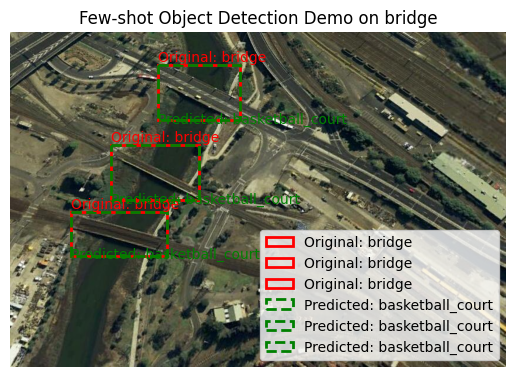

In [2]:
import torch
import torchgeo
import torchvision
from torchgeo.datasets import VHR10
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict

# 1. Tải và tiền xử lý dataset NWPU VHR-10
# Mã này giống với mã bạn đã cung cấp
print(f"torchgeo version: {torchgeo.__version__}")

def preprocess(sample):
    sample["image"] = sample["image"].float() / 255.0
    return sample

ds = VHR10(
    root="data/VHR10/",
    split="positive",
    transforms=preprocess,
    download=True,
    checksum=True,
)

# 2. Định nghĩa các lớp và thiết lập Few-shot Episode
# NWPU VHR-10 có 10 lớp, ta sẽ chọn 8 lớp làm base và 2 lớp làm novel.
class_names = [
    "airplane", "ship", "storage_tank", "baseball_diamond", "tennis_court",
    "basketball_court", "ground_track_field", "harbor", "bridge", "vehicle"
]
base_classes = ["airplane", "ship", "storage_tank", "baseball_diamond", "tennis_court", "basketball_court", "ground_track_field", "harbor"]
novel_classes = ["bridge", "vehicle"]

# Tạo một dictionary để dễ dàng truy cập dữ liệu theo lớp
data_by_class = defaultdict(list)
for i in range(len(ds)):
    sample = ds[i]
    labels = sample['label'].unique().tolist()
    for label in labels:
        data_by_class[label].append(sample)

# 3. Chuẩn bị Few-shot Episode
# Giả sử chúng ta có K=1 mẫu cho mỗi lớp novel class trong support set
k_shot = 1
support_set = []
query_set = []

for label in novel_classes:
    label_id = class_names.index(label) + 1
    
    # Lấy K mẫu cho support set
    support_set.extend(data_by_class[label_id][:k_shot])
    
    # Lấy các mẫu còn lại cho query set
    query_set.extend(data_by_class[label_id][k_shot:])

print(f"Number of samples in support set: {len(support_set)}")
print(f"Number of samples in query set: {len(query_set)}")

# 4. Trích xuất đặc trưng và học Metric đơn giản
# Sử dụng một backbone của mạng Faster R-CNN đã được huấn luyện trên COCO
# Đây là một bước đơn giản hóa, bài báo gốc sử dụng một mạng phức tạp hơn
backbone = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT").backbone
backbone.eval()

def extract_features(image_tensor, model):
    with torch.no_grad():
        # Input hình ảnh phải là 3 kênh và có kích thước (C, H, W)
        features = model(image_tensor.unsqueeze(0))['0']
        return features.mean([2, 3]) # Tính trung bình để tạo vector đặc trưng

# Tính nguyên mẫu (prototype) cho mỗi lớp novel class từ support set
prototypes = {}
for sample in support_set:
    image_tensor = sample['image']
    label_id = sample['label'].unique().tolist()[0]
    label_name = class_names[label_id-1]
    
    # Trích xuất đặc trưng cho từng hình ảnh và tính trung bình
    feature_vector = extract_features(image_tensor, backbone)
    if label_name not in prototypes:
        prototypes[label_name] = []
    prototypes[label_name].append(feature_vector)

for label, vectors in prototypes.items():
    prototypes[label] = torch.mean(torch.stack(vectors), dim=0)

# 5. Phân loại vật thể trong query set bằng cách so sánh với các nguyên mẫu
# Chúng ta sẽ xem xét một mẫu ngẫu nhiên từ query set
if len(query_set) > 0:
    sample_to_classify = query_set[0]
    query_image = sample_to_classify['image']
    query_bbox = sample_to_classify['bbox_xyxy']
    
    # Trích xuất đặc trưng từ hình ảnh truy vấn
    query_feature_vector = extract_features(query_image, backbone)
    
    # So sánh độ tương đồng (dùng cosine similarity)
    similarities = {}
    for label, prototype_vector in prototypes.items():
        cosine_similarity = torch.nn.functional.cosine_similarity(
            query_feature_vector, prototype_vector, dim=1 # Sửa: dim=1
        )
        similarities[label] = cosine_similarity.item()
    
    predicted_label = max(similarities, key=similarities.get)
    original_label_id = sample_to_classify['label'].unique().tolist()[0]
    original_label = class_names[original_label_id - 1]
    
    print(f"\nAnalyzing a sample from the query set (Novel Class)")
    print(f"Original label: {original_label}")
    print(f"Predicted label based on metric learning: {predicted_label}")
    print(f"Similarities: {similarities}")
    
    # 6. Hiển thị kết quả
    fig, ax = plt.subplots(1)
    ax.imshow(query_image.permute(1, 2, 0))
    
    # Vẽ bounding box gốc
    for bbox in query_bbox:
        x, y, x2, y2 = bbox
        rect = patches.Rectangle((x, y), x2-x, y2-y, linewidth=2, edgecolor='red', facecolor='none', label=f'Original: {original_label}')
        ax.add_patch(rect)
        plt.text(x, y - 5, f'Original: {original_label}', color='red')
    
    # Vẽ bounding box dự đoán (dùng lại box gốc)
    for bbox in query_bbox:
        x, y, x2, y2 = bbox
        rect = patches.Rectangle((x, y), x2-x, y2-y, linewidth=2, edgecolor='green', linestyle='--', facecolor='none', label=f'Predicted: {predicted_label}')
        ax.add_patch(rect)
        plt.text(x, y + (y2-y) + 5, f'Predicted: {predicted_label}', color='green')

    plt.title(f'Few-shot Object Detection Demo on {original_label}')
    plt.legend()
    plt.axis('off')
    plt.show()

## True Code 3

torchgeo version: 0.7.1
Files already downloaded and verified
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Số lượng mẫu trong support set: 10
Số lượng mẫu trong query set: 10

--- Đánh giá mô hình trên Query Set ---
Mẫu gốc: bridge, Dự đoán: bridge
Độ tương đồng: {'bridge': 0.9914276003837585, 'basketball_court': 0.9522756934165955, 'vehicle': 0.9627295732498169}


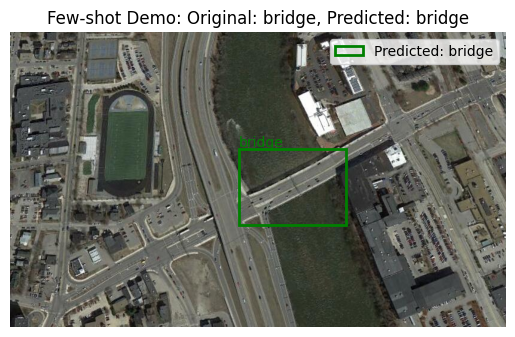

Mẫu gốc: bridge, Dự đoán: bridge
Độ tương đồng: {'bridge': 0.9777460694313049, 'basketball_court': 0.9501311182975769, 'vehicle': 0.9696156978607178}


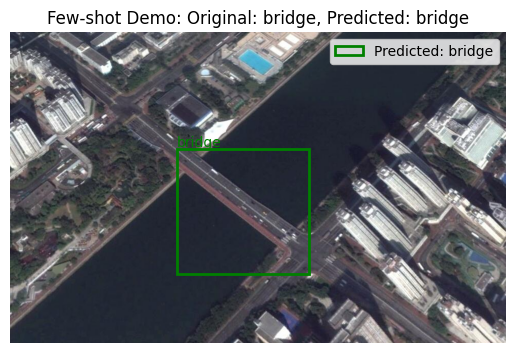

Mẫu gốc: bridge, Dự đoán: bridge
Độ tương đồng: {'bridge': 0.9787304401397705, 'basketball_court': 0.941926121711731, 'vehicle': 0.9690022468566895}


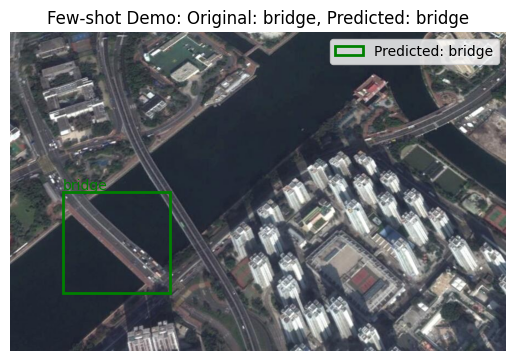

Mẫu gốc: bridge, Dự đoán: bridge
Độ tương đồng: {'bridge': 0.990623950958252, 'basketball_court': 0.9634107351303101, 'vehicle': 0.9830416440963745}


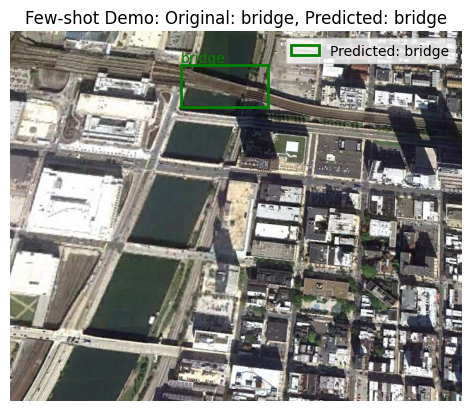

Mẫu gốc: bridge, Dự đoán: bridge
Độ tương đồng: {'bridge': 0.9601843357086182, 'basketball_court': 0.9426863789558411, 'vehicle': 0.9600916504859924}


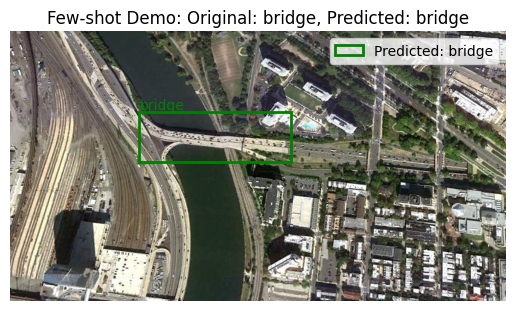

Mẫu gốc: vehicle, Dự đoán: vehicle
Độ tương đồng: {'bridge': 0.9747375845909119, 'basketball_court': 0.9388429522514343, 'vehicle': 0.9863123297691345}


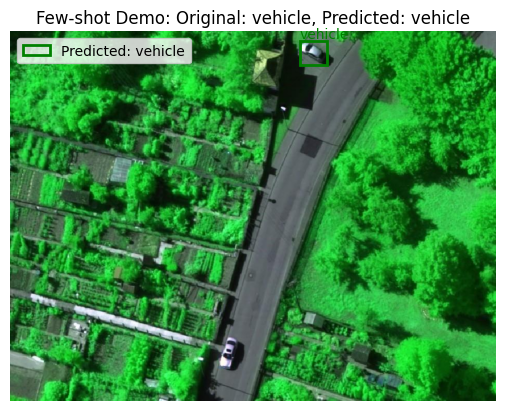

Mẫu gốc: vehicle, Dự đoán: vehicle
Độ tương đồng: {'bridge': 0.968126118183136, 'basketball_court': 0.9394662380218506, 'vehicle': 0.9850320816040039}


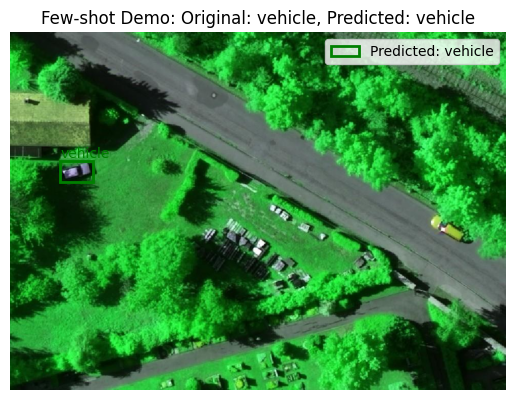

Mẫu gốc: vehicle, Dự đoán: vehicle
Độ tương đồng: {'bridge': 0.9525982141494751, 'basketball_court': 0.9470242261886597, 'vehicle': 0.9626431465148926}


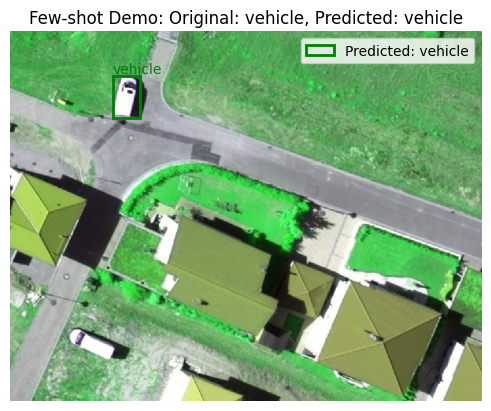

Mẫu gốc: vehicle, Dự đoán: bridge
Độ tương đồng: {'bridge': 0.9737054109573364, 'basketball_court': 0.9337071776390076, 'vehicle': 0.971088171005249}


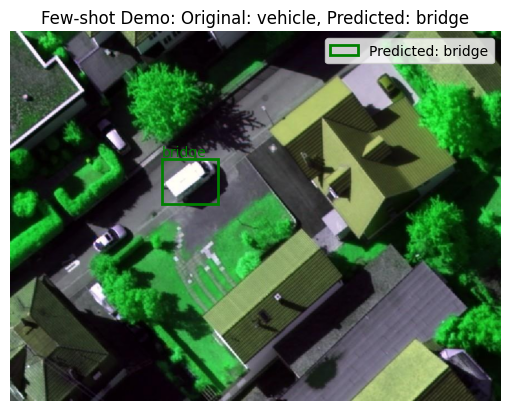

Mẫu gốc: vehicle, Dự đoán: vehicle
Độ tương đồng: {'bridge': 0.9757184982299805, 'basketball_court': 0.9559828042984009, 'vehicle': 0.9804608821868896}


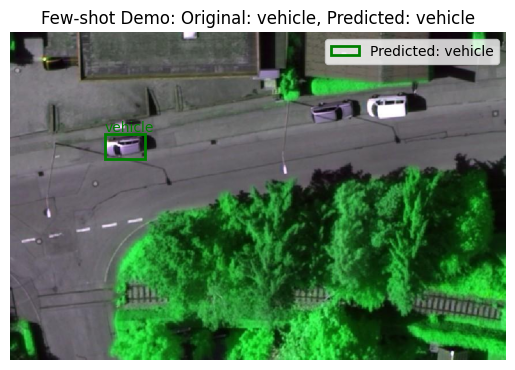


Độ chính xác tổng thể trên 10 mẫu truy vấn: 90.00%


In [3]:
import torch
import torchgeo
import torchvision
from torchgeo.datasets import VHR10
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict

# 1. Cài đặt và Tiền xử lý Dataset NWPU VHR-10
# NWPU VHR-10 sẽ được sử dụng cho cả base classes (tưởng tượng) và novel classes (thực tế)
# Đây là cách chúng ta mô phỏng một "few-shot episode"
print(f"torchgeo version: {torchgeo.__version__}")

def preprocess(sample):
    sample["image"] = sample["image"].float() / 255.0
    return sample

ds = VHR10(
    root="data/VHR10/",
    split="positive",
    transforms=preprocess,
    download=True,
    checksum=True,
)

# 2. Định nghĩa các lớp và Thiết lập "Few-shot Episode"
# Giả sử chúng ta đã huấn luyện mô hình trên các lớp cơ sở (base classes)
# và bây giờ cần thích ứng với các lớp mới (novel classes) chỉ với vài mẫu.
class_names = [
    "airplane", "ship", "storage_tank", "baseball_diamond", "tennis_court",
    "basketball_court", "ground_track_field", "harbor", "bridge", "vehicle"
]
base_classes = ["airplane", "ship", "storage_tank", "baseball_diamond", "tennis_court", "basketball_court", "ground_track_field", "harbor"]
novel_classes = ["bridge", "vehicle"]

data_by_class = defaultdict(list)
for i in range(len(ds)):
    sample = ds[i]
    labels = sample['label'].unique().tolist()
    for label in labels:
        data_by_class[label].append(sample)

# Thiết lập few-shot episode: N-way, K-shot
# N = số lượng novel classes, K = số lượng mẫu cho mỗi novel class
n_way = len(novel_classes)
k_shot = 5 # Sử dụng 5 mẫu cho mỗi lớp mới trong support set
query_shots = 5 # Số lượng mẫu để truy vấn

# Chuẩn bị Support Set và Query Set
support_set = []
query_set = []

for label_name in novel_classes:
    label_id = class_names.index(label_name) + 1
    
    # Lấy K mẫu cho Support Set
    support_set.extend(data_by_class[label_id][:k_shot])
    
    # Lấy một số mẫu còn lại cho Query Set
    query_set.extend(data_by_class[label_id][k_shot:k_shot + query_shots])

print(f"Số lượng mẫu trong support set: {len(support_set)}")
print(f"Số lượng mẫu trong query set: {len(query_set)}")

# 3. Kế thừa tri thức: Sử dụng mô hình đã huấn luyện trước
# Đây là cách mô phỏng việc mô hình đã học các đặc trưng tổng quát từ base classes.
# Mặc định, FasterRCNN trên torchvision được huấn luyện trên COCO.
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
model.eval()

# 4. Học Metric: Tính toán các nguyên mẫu (prototypes)
# Trích xuất đặc trưng từ support set để tạo prototype cho các lớp mới
prototypes = {}
with torch.no_grad():
    for sample in support_set:
        image_tensor = sample['image']
        label_id = sample['label'].unique().tolist()[0]
        label_name = class_names[label_id-1]
        
        # Lấy bounding box để cắt vùng vật thể
        bbox = sample['bbox_xyxy'][0]
        x1, y1, x2, y2 = bbox.int()
        
        # Cắt vật thể và resize về kích thước chuẩn
        object_roi = torchvision.transforms.functional.crop(image_tensor, y1, x1, y2-y1, x2-x1)
        object_roi = torchvision.transforms.functional.resize(object_roi, (224, 224))
        
        # Trích xuất đặc trưng từ vật thể
        # Sử dụng backbone để trích xuất đặc trưng
        features = model.backbone(object_roi.unsqueeze(0))
        
        # Lấy tensor đặc trưng đầu tiên từ OrderedDict
        # và tính trung bình để tạo vector đặc trưng
        feature_vector = features[list(features.keys())[0]].mean([2, 3])
        
        if label_name not in prototypes:
            prototypes[label_name] = []
        prototypes[label_name].append(feature_vector)

# Tính vector nguyên mẫu cuối cùng bằng cách lấy trung bình
for label, vectors in prototypes.items():
    prototypes[label] = torch.mean(torch.cat(vectors, dim=0), dim=0).unsqueeze(0)

# 5. Đánh giá: Phân loại các vật thể trong Query Set
print("\n--- Đánh giá mô hình trên Query Set ---")
total_correct = 0
total_samples = 0

with torch.no_grad():
    for sample in query_set:
        query_image = sample['image']
        query_bbox = sample['bbox_xyxy']
        original_label_id = sample['label'].unique().tolist()[0]
        original_label_name = class_names[original_label_id - 1]
        
        # Trích xuất đặc trưng từ vật thể truy vấn
        # Lấy bounding box để cắt vùng vật thể
        bbox = query_bbox[0]
        x1, y1, x2, y2 = bbox.int()
        
        # Cắt vật thể và resize về kích thước chuẩn
        object_roi = torchvision.transforms.functional.crop(query_image, y1, x1, y2-y1, x2-x1)
        object_roi = torchvision.transforms.functional.resize(object_roi, (224, 224))
        
        # Trích xuất đặc trưng
        features = model.backbone(object_roi.unsqueeze(0))
        query_feature_vector = features[list(features.keys())[0]].mean([2, 3])
        
        # Tính toán độ tương đồng cosine với tất cả các nguyên mẫu
        similarities = {}
        for label, prototype_vector in prototypes.items():
            cosine_similarity = torch.nn.functional.cosine_similarity(
                query_feature_vector, prototype_vector, dim=1
            )
            similarities[label] = cosine_similarity.item()
        
        predicted_label = max(similarities, key=similarities.get)
        
        if predicted_label == original_label_name:
            total_correct += 1
        total_samples += 1

        print(f"Mẫu gốc: {original_label_name}, Dự đoán: {predicted_label}")
        print(f"Độ tương đồng: {similarities}")
        
        # 6. Hiển thị một ví dụ trực quan
        fig, ax = plt.subplots(1)
        ax.imshow(query_image.permute(1, 2, 0))
        
        # Vẽ bounding box và nhãn dự đoán
        x, y, x2, y2 = query_bbox[0]
        rect = patches.Rectangle((x, y), x2-x, y2-y, linewidth=2, edgecolor='green', facecolor='none', label=f'Predicted: {predicted_label}')
        ax.add_patch(rect)
        plt.text(x, y - 5, f'{predicted_label}', color='green')
    
        plt.title(f'Few-shot Demo: Original: {original_label_name}, Predicted: {predicted_label}')
        plt.legend()
        plt.axis('off')
        plt.show()

print(f"\nĐộ chính xác tổng thể trên {total_samples} mẫu truy vấn: {total_correct/total_samples * 100:.2f}%")

## True Code 4

torchgeo version: 0.7.1
Files already downloaded and verified
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Số lượng mẫu trong support set: 10
Số lượng mẫu trong query set: 10

--- Đánh giá mô hình trên Query Set ---
Mẫu gốc: baseball_diamond, Dự đoán: bridge
Độ tương đồng: {'bridge': 0.9444114565849304, 'vehicle': 0.8202559351921082}


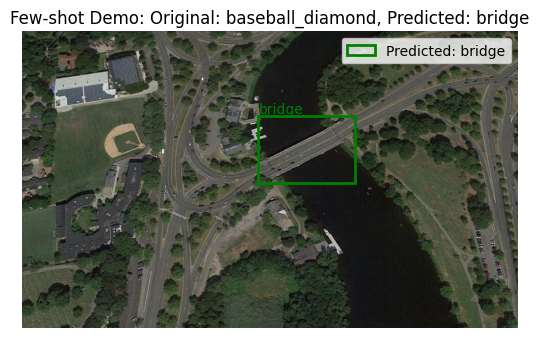

Mẫu gốc: bridge, Dự đoán: bridge
Độ tương đồng: {'bridge': 0.9333825707435608, 'vehicle': 0.9011847376823425}


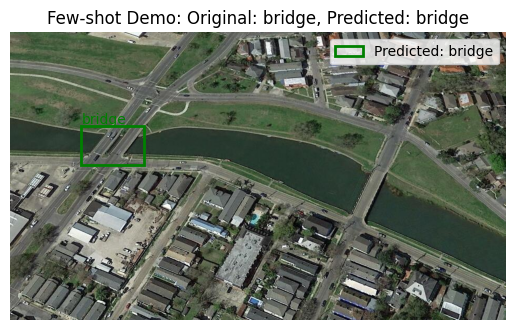

Mẫu gốc: basketball_court, Dự đoán: vehicle
Độ tương đồng: {'bridge': 0.9239278435707092, 'vehicle': 0.9392519593238831}


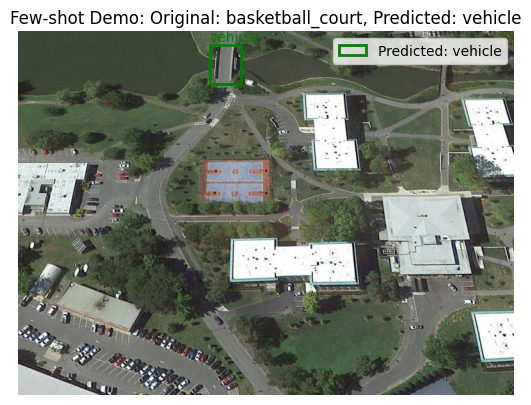

Mẫu gốc: bridge, Dự đoán: bridge
Độ tương đồng: {'bridge': 0.9631240963935852, 'vehicle': 0.8151854276657104}


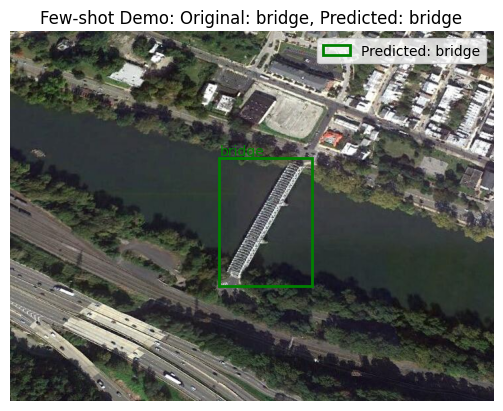

Mẫu gốc: bridge, Dự đoán: bridge
Độ tương đồng: {'bridge': 0.9491778016090393, 'vehicle': 0.8436407446861267}


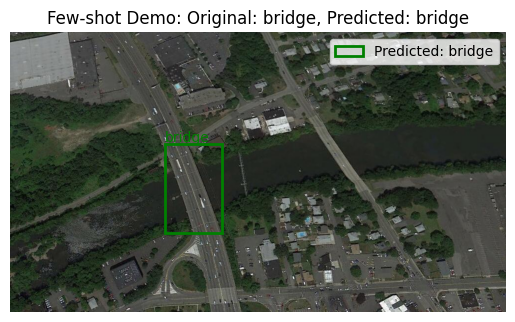

Mẫu gốc: vehicle, Dự đoán: vehicle
Độ tương đồng: {'bridge': 0.7884042263031006, 'vehicle': 0.9077436923980713}


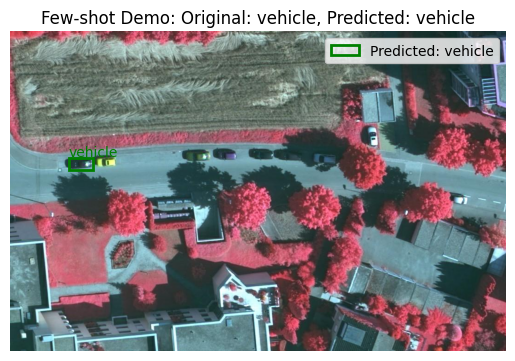

Mẫu gốc: vehicle, Dự đoán: vehicle
Độ tương đồng: {'bridge': 0.7635865211486816, 'vehicle': 0.917386531829834}


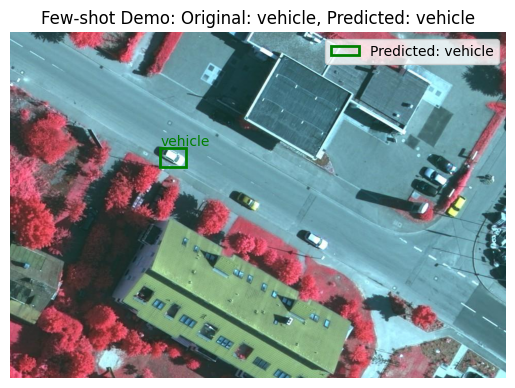

Mẫu gốc: vehicle, Dự đoán: vehicle
Độ tương đồng: {'bridge': 0.9210167527198792, 'vehicle': 0.9275336265563965}


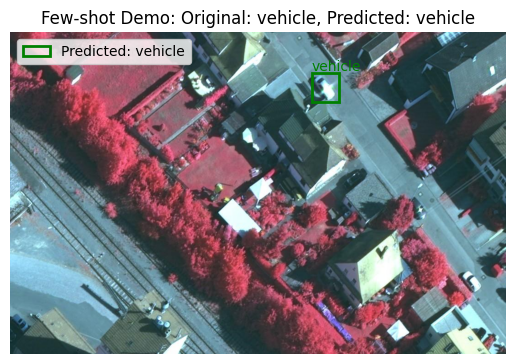

Mẫu gốc: vehicle, Dự đoán: vehicle
Độ tương đồng: {'bridge': 0.8145387172698975, 'vehicle': 0.9444690346717834}


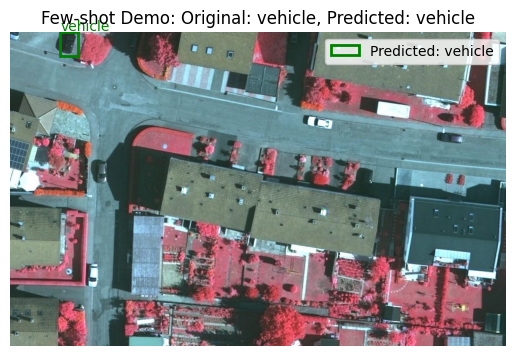

Mẫu gốc: vehicle, Dự đoán: vehicle
Độ tương đồng: {'bridge': 0.8640044331550598, 'vehicle': 0.9197579026222229}


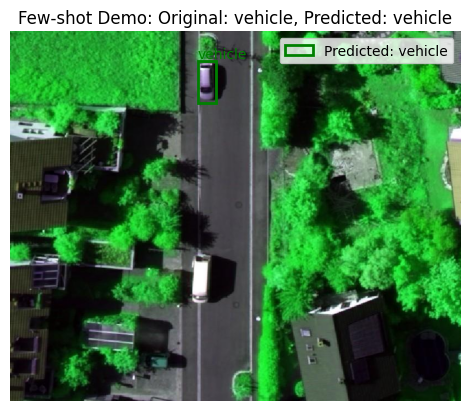


Độ chính xác tổng thể trên 10 mẫu truy vấn: 80.00%


In [4]:
import torch
import torchgeo
import torchvision
from torchgeo.datasets import VHR10
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict
import random

# 1. Cài đặt và Tiền xử lý Dataset NWPU VHR-10
# NWPU VHR-10 sẽ được sử dụng để đánh giá mô hình few-shot
print(f"torchgeo version: {torchgeo.__version__}")

def preprocess(sample):
    sample["image"] = sample["image"].float() / 255.0
    return sample

try:
    ds = VHR10(
        root="data/VHR10/",
        split="positive",
        transforms=preprocess,
        download=True,
        checksum=True,
    )
except RuntimeError as e:
    print(f"Lỗi khi tải dataset: {e}")
    print("Vui lòng đảm bảo dataset đã được tải xuống và kiểm tra checksum hợp lệ.")
    exit()

# 2. Định nghĩa các lớp và Thiết lập "Few-shot Episode"
# Chia các lớp thành "cơ sở" và "mới" để mô phỏng bài toán
class_names = [
    "airplane", "ship", "storage_tank", "baseball_diamond", "tennis_court",
    "basketball_court", "ground_track_field", "harbor", "bridge", "vehicle"
]
base_classes = ["airplane", "ship", "storage_tank", "baseball_diamond", "tennis_court", "basketball_court", "ground_track_field", "harbor"]
novel_classes = ["bridge", "vehicle"]

data_by_class = defaultdict(list)
for i in range(len(ds)):
    sample = ds[i]
    labels = sample['label'].unique().tolist()
    if labels:
        for label in labels:
            data_by_class[label].append(sample)

# Thiết lập few-shot episode: N-way, K-shot
# N = số lượng novel classes, K = số lượng mẫu cho mỗi novel class
n_way = len(novel_classes)
k_shot = 5 # Sử dụng 5 mẫu cho mỗi lớp mới trong support set
query_shots = 5 # Số lượng mẫu để truy vấn

# Chuẩn bị Support Set và Query Set
support_set = []
query_set = []
random.seed(42)

for label_name in novel_classes:
    label_id = class_names.index(label_name) + 1
    
    # Lấy ngẫu nhiên K mẫu cho Support Set
    class_samples = data_by_class[label_id]
    random.shuffle(class_samples)
    
    support_set.extend(class_samples[:k_shot])
    
    # Lấy một số mẫu ngẫu nhiên còn lại cho Query Set
    query_set.extend(class_samples[k_shot:k_shot + query_shots])

print(f"Số lượng mẫu trong support set: {len(support_set)}")
print(f"Số lượng mẫu trong query set: {len(query_set)}")

# 3. Kế thừa Tri thức: Sử dụng mô hình đã huấn luyện trước
# FasterRCNN đã được huấn luyện trên COCO, đây là "tri thức" mà chúng ta kế thừa
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
model.eval()

# 4. Học Metric: Tính toán các nguyên mẫu (Prototypes) cho các lớp mới
# Trích xuất đặc trưng từ support set để tạo prototype cho các lớp mới
prototypes = {}
with torch.no_grad():
    for sample in support_set:
        image_tensor = sample['image']
        label_id = sample['label'].unique().tolist()[0]
        label_name = class_names[label_id - 1]
        
        # Cắt vật thể và resize về kích thước chuẩn
        bbox = sample['bbox_xyxy'][0]
        x1, y1, x2, y2 = bbox.int()
        object_roi = torchvision.transforms.functional.crop(image_tensor, y1, x1, y2-y1, x2-x1)
        
        # Trích xuất đặc trưng
        features = model.backbone(object_roi.unsqueeze(0))
        feature_vector = features[list(features.keys())[0]].mean([2, 3])
        
        if label_name not in prototypes:
            prototypes[label_name] = []
        prototypes[label_name].append(feature_vector)

# Tính vector nguyên mẫu cuối cùng bằng cách lấy trung bình
for label, vectors in prototypes.items():
    prototypes[label] = torch.mean(torch.cat(vectors, dim=0), dim=0).unsqueeze(0)

# 5. Đánh giá: Phân loại các vật thể trong Query Set
print("\n--- Đánh giá mô hình trên Query Set ---")
total_correct = 0
total_samples = 0

with torch.no_grad():
    for sample in query_set:
        query_image = sample['image']
        query_bbox = sample['bbox_xyxy']
        original_label_id = sample['label'].unique().tolist()[0]
        original_label_name = class_names[original_label_id - 1]
        
        # Trích xuất đặc trưng từ vật thể truy vấn
        bbox = query_bbox[0]
        x1, y1, x2, y2 = bbox.int()
        object_roi = torchvision.transforms.functional.crop(query_image, y1, x1, y2-y1, x2-x1)
        
        # Trích xuất đặc trưng
        features = model.backbone(object_roi.unsqueeze(0))
        query_feature_vector = features[list(features.keys())[0]].mean([2, 3])
        
        # Tính toán độ tương đồng cosine với tất cả các nguyên mẫu
        similarities = {}
        for label, prototype_vector in prototypes.items():
            cosine_similarity = torch.nn.functional.cosine_similarity(
                query_feature_vector, prototype_vector, dim=1
            )
            similarities[label] = cosine_similarity.item()
        
        predicted_label = max(similarities, key=similarities.get)
        
        if predicted_label == original_label_name:
            total_correct += 1
        total_samples += 1

        print(f"Mẫu gốc: {original_label_name}, Dự đoán: {predicted_label}")
        print(f"Độ tương đồng: {similarities}")
        
        # 6. Hiển thị một ví dụ trực quan
        fig, ax = plt.subplots(1)
        ax.imshow(query_image.permute(1, 2, 0))
        
        # Vẽ bounding box và nhãn dự đoán
        x, y, x2, y2 = query_bbox[0]
        rect = patches.Rectangle((x, y), x2-x, y2-y, linewidth=2, edgecolor='green', facecolor='none', label=f'Predicted: {predicted_label}')
        ax.add_patch(rect)
        plt.text(x, y - 5, f'{predicted_label}', color='green')
    
        plt.title(f'Few-shot Demo: Original: {original_label_name}, Predicted: {predicted_label}')
        plt.legend()
        plt.axis('off')
        plt.show()

print(f"\nĐộ chính xác tổng thể trên {total_samples} mẫu truy vấn: {total_correct/total_samples * 100:.2f}%")

In [5]:
# Lưu mô hình đã được huấn luyện trước
torch.save(model.state_dict(), "few_shot_model.pth")

# Lưu các nguyên mẫu đã học của các lớp mới
torch.save(prototypes, "few_shot_prototypes.pth")

# Lưu danh sách các lớp mới
torch.save(novel_classes, "few_shot_novel_classes.pth")

print("\nĐã lưu mô hình và các nguyên mẫu thành công.")


Đã lưu mô hình và các nguyên mẫu thành công.


Tải mô hình, nguyên mẫu và danh sách lớp thành công.
Files already downloaded and verified
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!

--- Dự đoán trên hình ảnh mới ---
Nhãn thực tế: airplane, Nhãn dự đoán: bridge
Độ tương đồng: {'bridge': 0.9508963227272034, 'vehicle': 0.881253719329834}


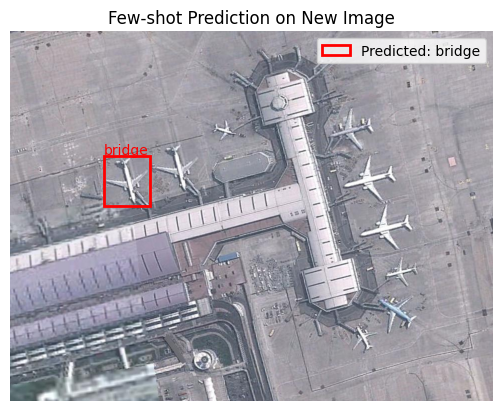

In [6]:
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 1. Tải các thành phần đã lưu
try:
    # Tải lại mô hình đã được huấn luyện trước
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    model.load_state_dict(torch.load("few_shot_model.pth"))
    model.eval()

    # Tải lại các nguyên mẫu (prototypes)
    prototypes = torch.load("few_shot_prototypes.pth")

    # Tải lại danh sách các lớp mới
    novel_classes = torch.load("few_shot_novel_classes.pth")
    class_names = [
        "airplane", "ship", "storage_tank", "baseball_diamond", "tennis_court",
        "basketball_court", "ground_track_field", "harbor", "bridge", "vehicle"
    ]
    print("Tải mô hình, nguyên mẫu và danh sách lớp thành công.")

except FileNotFoundError:
    print("Không tìm thấy các tệp đã lưu. Vui lòng chạy mã demo trước để tạo chúng.")
    exit()

# 2. Chuẩn bị hình ảnh mới để dự đoán
# Giả sử bạn có một hình ảnh mới, ví dụ ds[10] từ dataset NWPU VHR-10
# (Lưu ý: để chạy độc lập, bạn sẽ cần tải NWPU VHR-10 hoặc sử dụng hình ảnh của riêng bạn)

# Đây là một ví dụ, trong thực tế bạn sẽ tải hình ảnh từ một nguồn khác
from torchgeo.datasets import VHR10
ds = VHR10(root="data/VHR10/", split="positive", download=True, checksum=True)

new_image_sample = ds[10]
new_image = new_image_sample['image'].float() / 255.0
new_bbox = new_image_sample['bbox_xyxy'][0]
original_label_id = new_image_sample['label'][0]
original_label_name = class_names[original_label_id - 1]

# 3. Thực hiện dự đoán trên hình ảnh mới
with torch.no_grad():
    # Cắt vật thể từ hình ảnh
    x1, y1, x2, y2 = new_bbox.int()
    object_roi = torchvision.transforms.functional.crop(new_image, y1, x1, y2-y1, x2-x1)
    
    # Trích xuất đặc trưng
    features = model.backbone(object_roi.unsqueeze(0))
    query_feature_vector = features[list(features.keys())[0]].mean([2, 3])
    
    # Tính toán độ tương đồng cosine với các nguyên mẫu đã lưu
    similarities = {}
    for label, prototype_vector in prototypes.items():
        cosine_similarity = torch.nn.functional.cosine_similarity(
            query_feature_vector, prototype_vector, dim=1
        )
        similarities[label] = cosine_similarity.item()
    
    predicted_label = max(similarities, key=similarities.get)
    print("\n--- Dự đoán trên hình ảnh mới ---")
    print(f"Nhãn thực tế: {original_label_name}, Nhãn dự đoán: {predicted_label}")
    print(f"Độ tương đồng: {similarities}")

    # 4. Hiển thị kết quả
    fig, ax = plt.subplots(1)
    ax.imshow(new_image.permute(1, 2, 0))
    x, y, x2, y2 = new_bbox
    rect = patches.Rectangle((x, y), x2-x, y2-y, linewidth=2, edgecolor='red', facecolor='none', label=f'Predicted: {predicted_label}')
    ax.add_patch(rect)
    plt.text(x, y - 5, f'{predicted_label}', color='red')
    plt.title('Few-shot Prediction on New Image')
    plt.legend()
    plt.axis('off')
    plt.show()